In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_style('whitegrid')

In [8]:
def plot_correlogram(x, lags=None, title=None, ylim=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    if ylim:
            axes[1][0].set_ylim(ylim)
            axes[1][1].set_ylim(ylim)
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [9]:
air_passenger_df = pd.read_csv('AirPassengers.csv')
bitcoin_df = pd.read_csv('BITSTAMP_BTCUSD, 1D.csv')

air_passenger_df['Month'] = pd.to_datetime(air_passenger_df['Month'])
air_passenger_df.set_index('Month', inplace=True)

bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['time'], unit='s')
bitcoin_df.set_index('datetime', inplace=True)
bitcoin_df.drop(columns=['time', 'open', 'high', 'low', 'Plot', 'Lagged Liquidity (12 weeks)', 'Plot.1', 'Volume'], inplace=True)

In [11]:
bitcoin_df = (
    bitcoin_df
    .assign(returns=lambda x: np.log(x['close']).diff().dropna().mul(100))
    .dropna(subset= ['returns'])
)
bitcoin_df.head()

,close,returns
datetime,,
2024-07-25,65796,0.640383
2024-07-26,67921,3.178622
2024-07-27,67892,-0.042706
2024-07-28,68264,0.546433
2024-07-29,66780,-2.197891


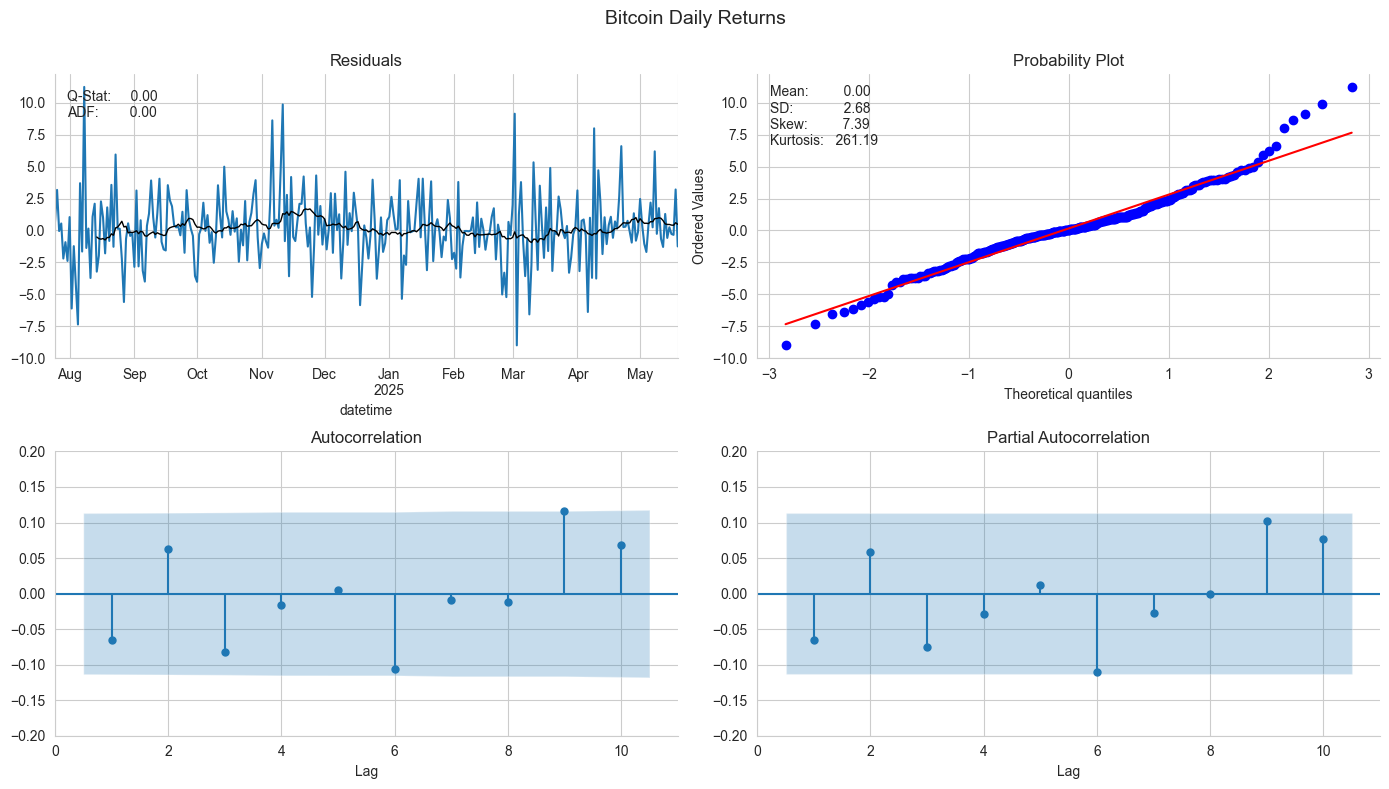

In [14]:
plot_correlogram(bitcoin_df['returns'], lags=10, title='Bitcoin Daily Returns', ylim=(-0.2,0.2))

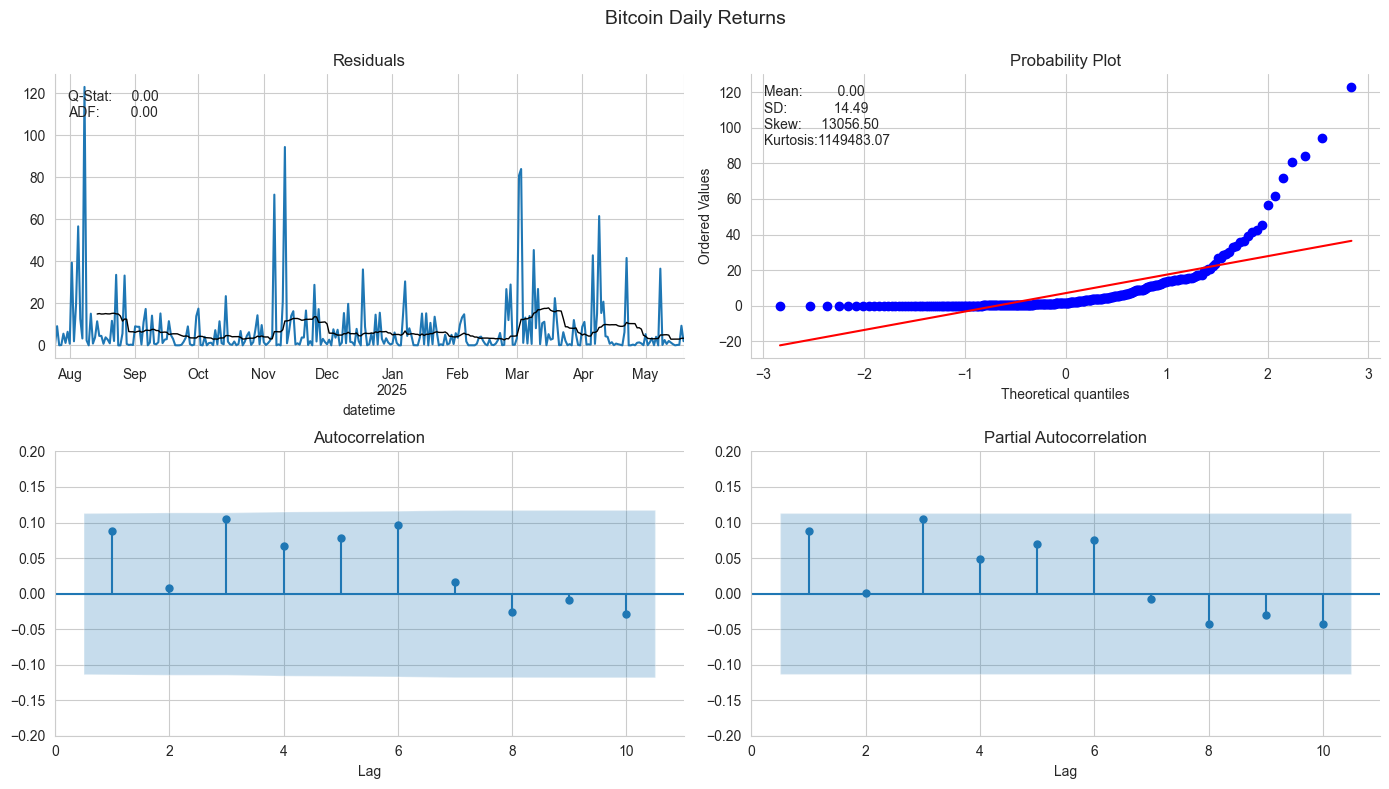

In [15]:
plot_correlogram(bitcoin_df['returns'].sub(bitcoin_df['returns'].mean()).pow(2), lags=10, title='Bitcoin Daily Returns', ylim=(-0.2,0.2))

In [23]:
trainsize = round(len(bitcoin_df['returns']) * 0.8)
data = bitcoin_df['returns'].clip(lower=bitcoin_df['returns'].quantile(.05),
                           upper=bitcoin_df['returns'].quantile(.95))
T = len(bitcoin_df['returns'])
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [24]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)

<Axes: xlabel='q', ylabel='p'>

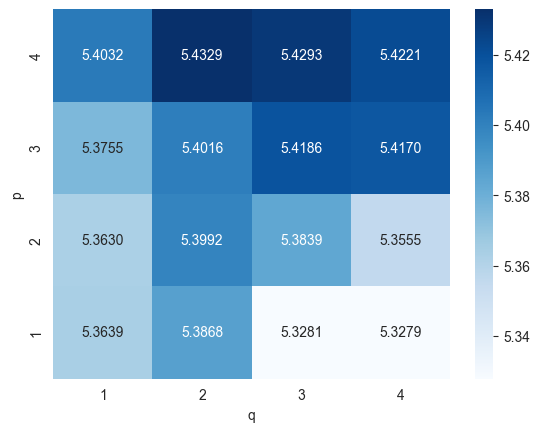

In [26]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')


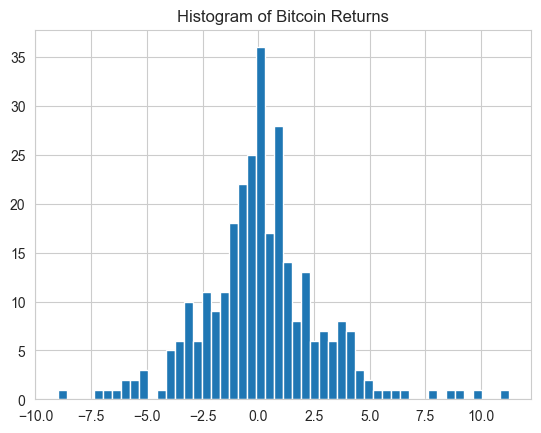

In [29]:
bitcoin_df['returns'].hist(bins=50)
plt.title('Histogram of Bitcoin Returns')
plt.show()


In [30]:
best_p, best_q = 1, 3,

In [31]:
am = ConstantMean(bitcoin_df['returns'].clip(lower=bitcoin_df['returns'].quantile(.05),
                                      upper=bitcoin_df['returns'].quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     41,   Neg. LLF: 654.7508522712651
Iteration:     10,   Func. Count:     79,   Neg. LLF: 654.6671118150142
Iteration:     15,   Func. Count:    113,   Neg. LLF: 654.6668895426204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 654.6668895427542
            Iterations: 15
            Function evaluations: 113
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -654.667
Distribution:                  Normal   AIC:                           1321.33
Method:            Maximum Likelihood   BIC:                           1343.54
                                        No. Observations:                  299
Date:                

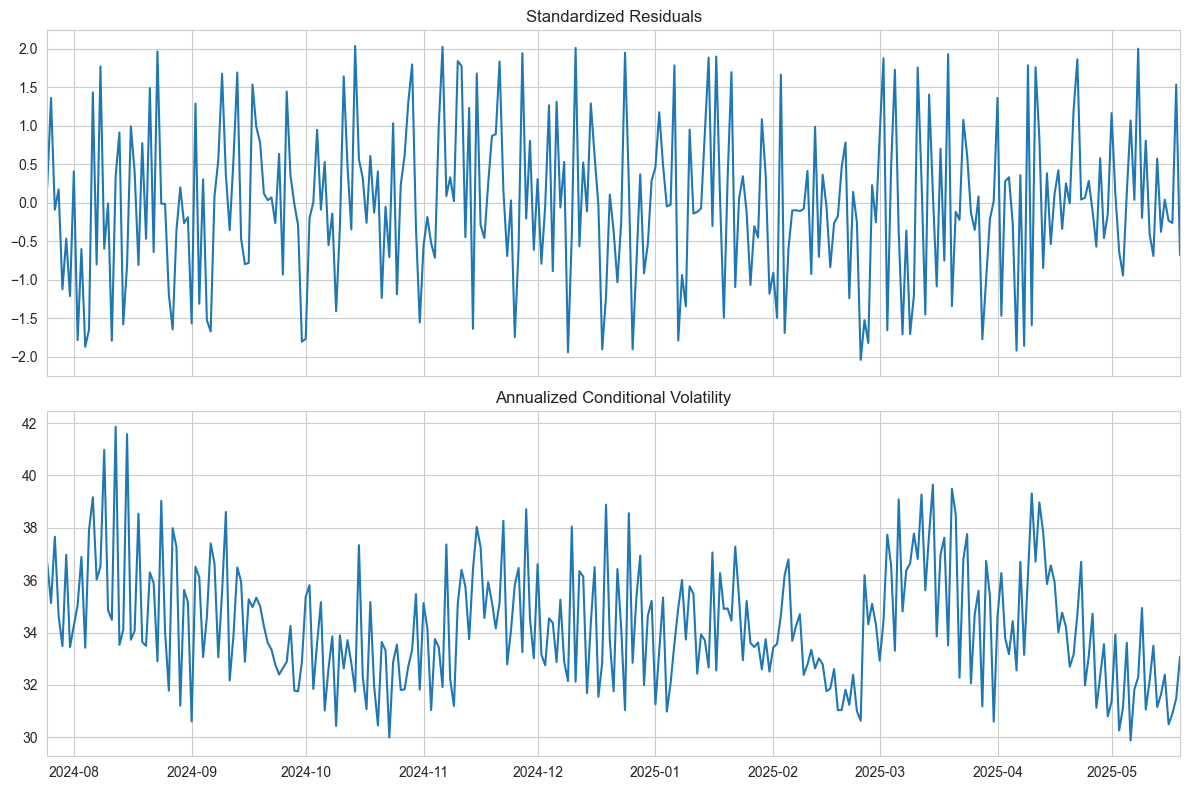

In [32]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

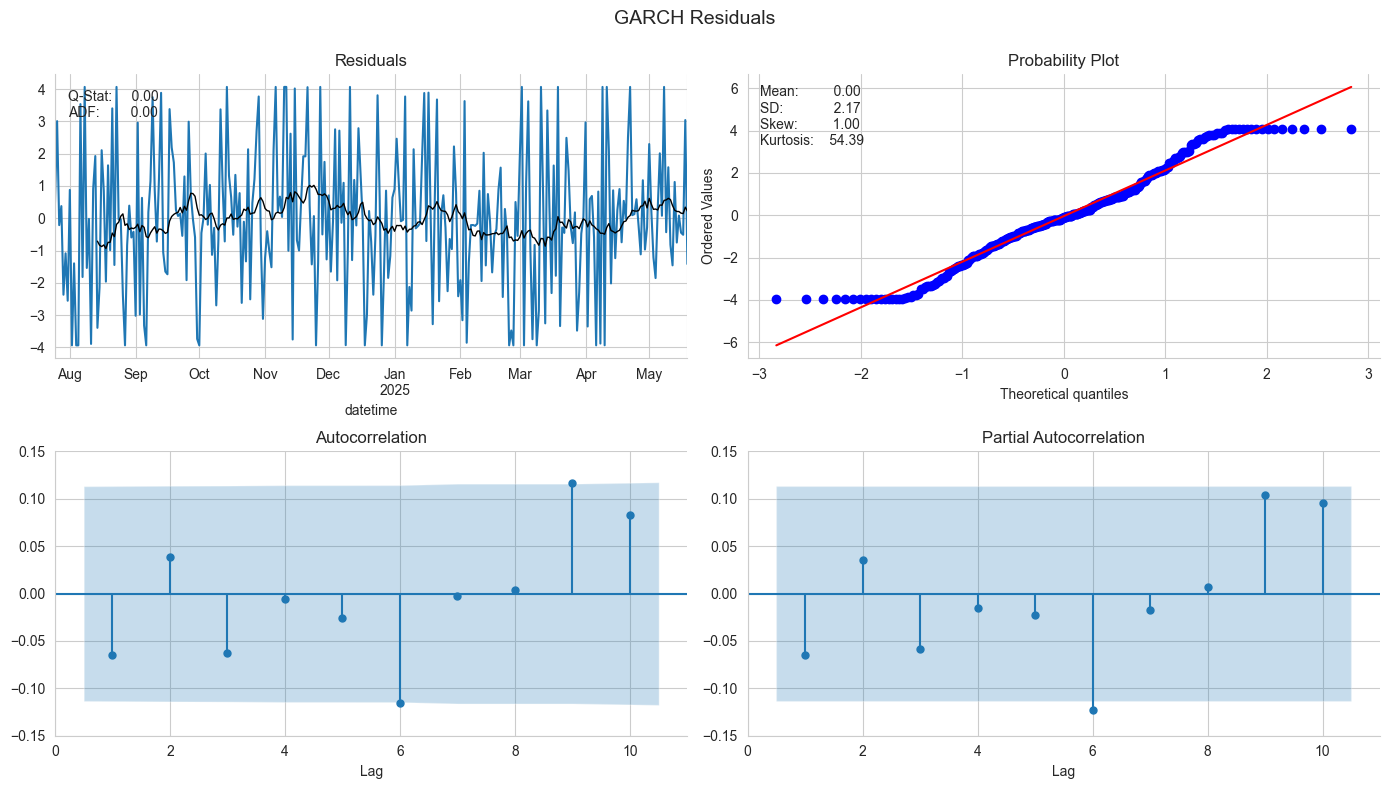

In [36]:
plot_correlogram(best_model.resid.dropna(),
                 lags=10,
                 title='GARCH Residuals', ylim=(-0.15, 0.15))